In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Import the data from the files into DataFrames and make datetime objects real datetime objects 
with open('Data/Dodgers.data','rb') as f:
    traffic = pd.read_csv(f,names=('Datetime','count'),encoding='ISO 8859-1')
    traffic['Datetime'] = pd.to_datetime(traffic.Datetime,format= '%m/%d/%Y %H:%M')
    
with open('Data/Dodgers.events','rb') as f:
    events = pd.read_csv(f,names=('Date','start_event','end_event','Game attendance','Away team','W/L score'),encoding='ISO 8859-1')
    events['start_event'] = pd.to_datetime(events.Date+'_'+events.start_event,format= '%m/%d/%y_%H:%M:%S')
    events['end_event'] = pd.to_datetime(events.Date+'_'+events.end_event,format= '%m/%d/%y_%H:%M:%S')
    events['Date'] = pd.to_datetime(events.Date,format= '%m/%d/%y')
    
with open('Data/CalIt2.data','r') as f:
    calTraffic = pd.read_csv(f,names=('direction','date','time','num'),encoding='iso-8859-1')
    calTraffic['datetime'] = pd.to_datetime(calTraffic.date+'_'+calTraffic.time,format= '%m/%d/%y_%H:%M:%S')
    calTraffic['date'] = pd.to_datetime(calTraffic.date,format= '%m/%d/%y')
    
with open('Data/CalIt2.events','rb') as f:
    calEvent= pd.read_csv(f,names=('Date','start_event','end_event','name'),encoding='ISO 8859-1') 
    calEvent['start_event'] = pd.to_datetime(calEvent.Date+'_'+calEvent.start_event,format= '%m/%d/%y_%H:%M:%S')
    calEvent['end_event'] = pd.to_datetime(calEvent.Date+'_'+calEvent.end_event,format= '%m/%d/%y_%H:%M:%S')
    calEvent['Date'] = pd.to_datetime(calEvent.Date,format= '%m/%d/%y')

events.head()



,Date,start_event,end_event,Game attendance,Away team,W/L score
0,2005-04-12,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,W 9-8
1,2005-04-13,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,W 4-1
2,2005-04-15,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,W 4-0
3,2005-04-16,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,W 8-3
4,2005-04-17,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,W 6-0


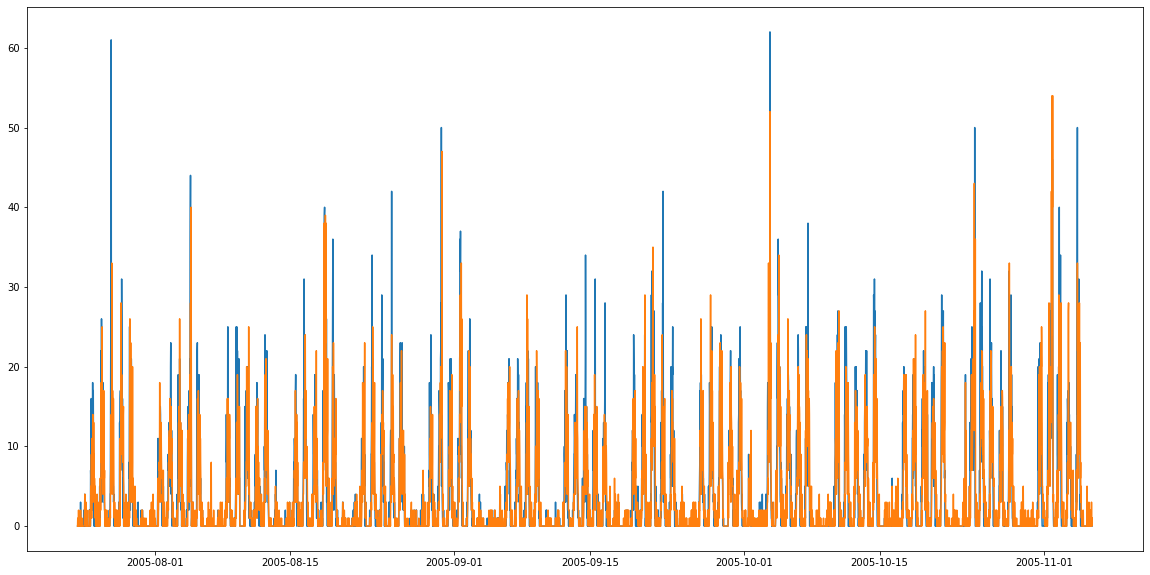

In [3]:
plt.figure(figsize=(20,10))

start = datetime.datetime.strptime("21-06-2014", "%d-%m-%Y")
end = datetime.datetime.strptime("07-07-2014", "%d-%m-%Y")

plt.plot(calTraffic[calTraffic.direction==9].datetime,calTraffic[calTraffic.direction==9].num)
plt.plot(calTraffic[calTraffic.direction==7].datetime,calTraffic[calTraffic.direction==7].num)

plt.show()



In [4]:
#Initiallize columns for events with outcomes and scores of home and away team
events['Outcome'] = 'W'
events['Score 1'] = 0
events['Score 2'] = 0


In [5]:
# Populate the scores with the data from the "W/L score" collumn
for ii in range(len(events)):
    #temp = re.split('  |- ', str(events.at[ii, 'W/L score']))
    temp1 = str(events.at[ii, 'W/L score']).split(' ')
    temp2 = temp1[1].split('-')
    events.at[ii, 'Outcome'] = temp1[0]
    events.at[ii, 'Score 1'] = int(temp2[0])
    events.at[ii, 'Score 2'] = int(temp2[1][:len(temp2[1])-1])


In [6]:
#one hot encode the win loss into 3 categoies (win loss and close game)
events['big_win'] = 0
events['big_loss'] = 0
events['close_game'] = 0

events.loc[list(events[(events['Outcome'] == 'W') & (events['Score 1']-events['Score 2']  > 3)].index), ['big_win']] = 1
events.loc[list(events[(events['Outcome'] == 'L') & (events['Score 1']-events['Score 2']  > 3)].index), ['big_loss']] = 1
events.loc[list(events[events['Score 1']-events['Score 2']  <= 3].index), ['close_game']] = 1
events.head(5)

,Date,start_event,end_event,Game attendance,Away team,W/L score,Outcome,Score 1,Score 2,big_win,big_loss,close_game
0,2005-04-12,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,W 9-8,W,9,8,0,0,1
1,2005-04-13,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,W 4-1,W,4,1,0,0,1
2,2005-04-15,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,W 4-0,W,4,0,1,0,0
3,2005-04-16,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,W 8-3,W,8,3,1,0,0
4,2005-04-17,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,W 6-0,W,6,0,1,0,0


In [7]:
# Drop -1 values from the traffic df
neg_indecies = traffic[traffic['count'] == -1].index
traffic =  traffic.drop(neg_indecies ,axis=0)
traffic = traffic.set_index('Datetime')
traffic = traffic.reset_index()


In [8]:
#create cols for the traffic df
traffic['big_win']=0
traffic['big_loss']=0
traffic['close_game']=0
traffic['no_game']=1

#assign each value in the traffic df to one of 4 groups, (Big Win, Big Loss, Close Game, No Game Being Played)
for i,(s,e,w,l,c) in events[['start_event','end_event','big_win','big_loss','close_game']].iterrows():    
    ind=traffic[s<traffic['Datetime']][traffic[s<traffic['Datetime']]['Datetime']<e].index
    traffic.iloc[list(ind[:]),[2,3,4]] = w,l,c
    
traffic['no_game']= traffic['no_game']-traffic['big_win']-traffic['big_loss']-traffic['close_game']


In [9]:
print(traffic['big_win'].sum() )
print(traffic['big_loss'].sum() )
print(traffic['close_game'].sum() )
print(traffic['no_game'].sum() )
print(traffic.shape)


507
506
1607
44877
(47497, 6)


In [10]:
# create a set of training examples, each being the length of one game with the length being constant. 
max_time = (events['end_event']-events['start_event']).max()
pad_time = datetime.timedelta(hours=1)
traffic.columns


Index(['Datetime', 'count', 'big_win', 'big_loss', 'close_game', 'no_game'], dtype='object')

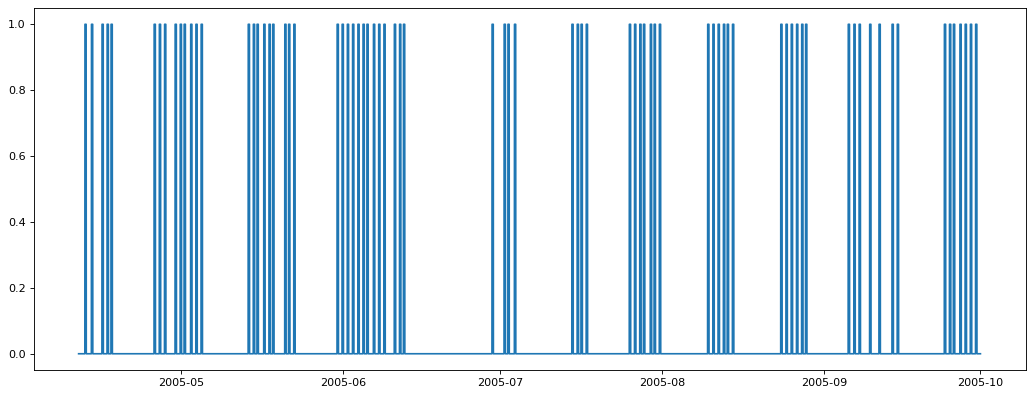

Index(['Datetime', 'count', 'big_win', 'big_loss', 'close_game', 'no_game',
       'game_time'],
      dtype='object')


In [11]:

#create cols to hold boolean for whether you are within 1 hour of a game
traffic['game_time']=0

for i,(s,_) in events[['start_event','end_event']].iterrows():  
    s,e = s-pad_time,s+max_time+pad_time
    ind=traffic[traffic['Datetime']>s][traffic[traffic['Datetime']>s]['Datetime']<e].index
    if len(ind) <72:
        # If there is missing data within the game time throw it out
        #print(len(ind))
        #print(events.values[i][1],events.values[i][1]+max_time+pad_time)
        traffic = traffic.drop(axis=0, index=ind)
        continue
    
    traffic.iloc[list(ind[:]),[6]] = 1

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(traffic['Datetime'],traffic['game_time'])
plt.show()
print(traffic.columns)


In [12]:
import tqdm

In [13]:

# Create 6 hour blocks to view traffic right before and right after the game
gt = traffic[['game_time']].values
flips= gt[1:]-gt[:-1]
ind = np.reshape(np.nonzero(flips)[0],[-1,2])

# Fill the dataframe with nans where there is a game to train the model
regular_traffic = traffic.copy()
for i,j in ind:
    regular_traffic.loc[i+1:j+1, 'count'] = np.nan

s=traffic['Datetime'].min()
e=traffic['Datetime'].max()
total_samples=(e-s).total_seconds()/300+1
time_steps = [s+datetime.timedelta(minutes=int(5*x)) for x in range(int(total_samples))]
rt = pd.DataFrame(time_steps,columns=['Datetime'])

col = list(regular_traffic.columns)
col.remove('Datetime')

#make all the other non datetime cols and fill with nan
rt[col] = pd.DataFrame([[np.nan for x in range(len(col))]], index=rt.index)

rt = rt.set_index('Datetime')



for ii in tqdm.tqdm_notebook(range(len(regular_traffic))):
#for ii in tqdm.tqdm_notebook(range(1000)):
    rt.loc[regular_traffic.iat[ii, 0], :] = regular_traffic.iloc[ii]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [15]:
rt = rt.reset_index()
rt

,Datetime,count,big_win,big_loss,close_game,no_game,game_time
0,2005-04-11 07:35:00,23.0,0.0,0.0,0.0,1.0,0.0
1,2005-04-11 07:40:00,42.0,0.0,0.0,0.0,1.0,0.0
2,2005-04-11 07:45:00,37.0,0.0,0.0,0.0,1.0,0.0
3,2005-04-11 07:50:00,24.0,0.0,0.0,0.0,1.0,0.0
4,2005-04-11 07:55:00,39.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
49730,2005-09-30 23:45:00,14.0,0.0,0.0,0.0,1.0,0.0
49731,2005-09-30 23:50:00,12.0,0.0,0.0,0.0,1.0,0.0
49732,2005-09-30 23:55:00,8.0,0.0,0.0,0.0,1.0,0.0
49733,2005-10-01 00:00:00,13.0,0.0,0.0,0.0,1.0,0.0


In [16]:
rt.to_csv('Cleaned_data')

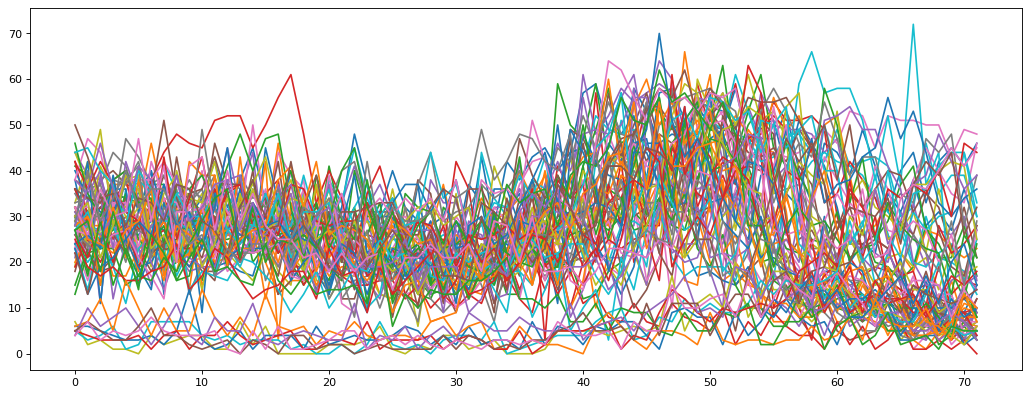

(77, 72, 7)


In [17]:
# create list to hold the 77 games 
data = []

#plot the 77 games on top of one graph
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(ind.shape[0]):
    #traffic['Datetime'].values[ind[i][0]:ind[i][1]]
    data.append(traffic[:].values[ind[i][0]:ind[i][1]])
    plt.plot( np.arange(0,72) , traffic['count'].values[ind[i][0]:ind[i][1]])
plt.show()

data = np.array(data)
print(data.shape)



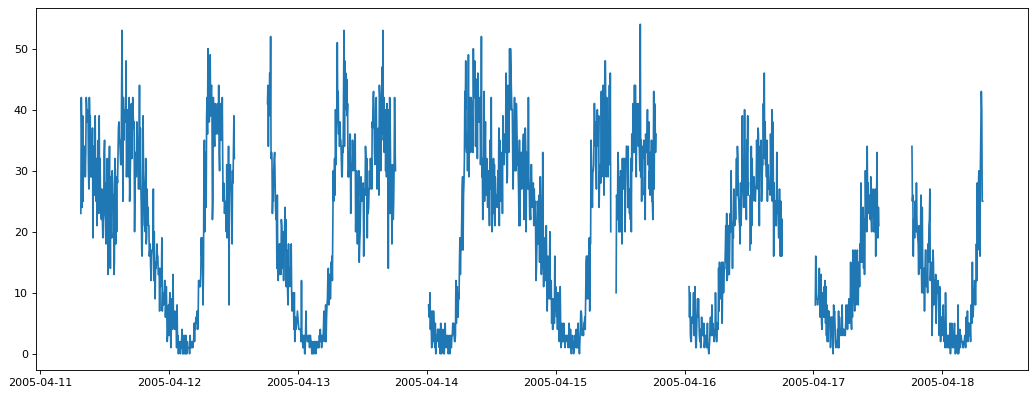

In [176]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rt['Datetime'][:2016], rt['count'][:2016])

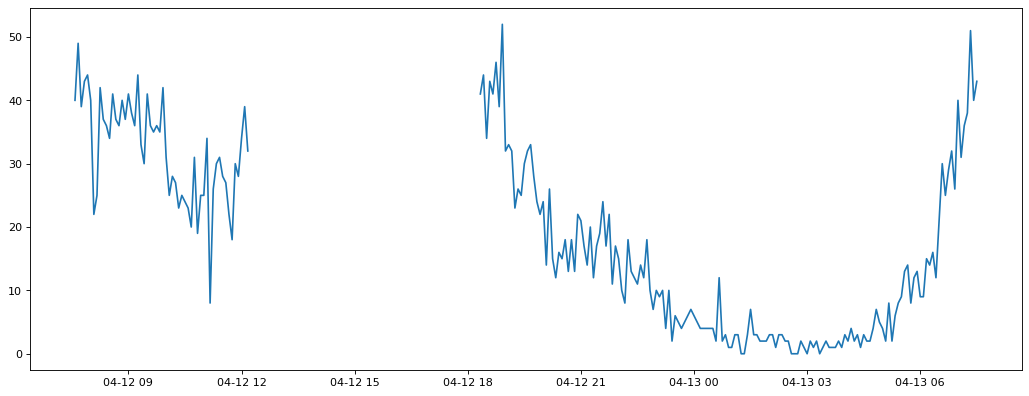

In [19]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rt['Datetime'][288:288*2], rt['count'][288:288*2])

In [20]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [178]:
model = UnobservedComponents(rt['count'], 
                                    level='local level', 
                                    freq_seasonal=[{'period': 331.56666667,
                                                    'harmonics': 1},
                                                   {'period': 292.55882353,
                                                    'harmonics': 1},
                                                  {'period': 290.84795322,
                                                    'harmonics': 1},
                                                   {'period':  274.77900552,
                                                    'harmonics': 1},
                                                  {'period': 143.74277457,
                                                    'harmonics': 1}])


In [179]:
output_res=model.fit(method='powell', disp=True)

Optimization terminated successfully.
         Current function value: 2.634630
         Iterations: 5
         Function evaluations: 458


In [180]:
output_res.summary()

Dep. Variable:,count,No. Observations:,49735
Model:,local level,Log Likelihood,-131033.347
,+ stochastic freq_seasonal(331.56666667(1)),AIC,262080.694
,+ stochastic freq_seasonal(292.55882353(1)),BIC,262142.394
,+ stochastic freq_seasonal(290.84795322(1)),HQIC,262100.026
,+ stochastic freq_seasonal(274.77900552(1)),,
,+ stochastic freq_seasonal(143.74277457(1)),,
Date:,"Sun, 15 Dec 2019",,
Time:,20:10:51,,
Sample:,0,,
,- 49735,,


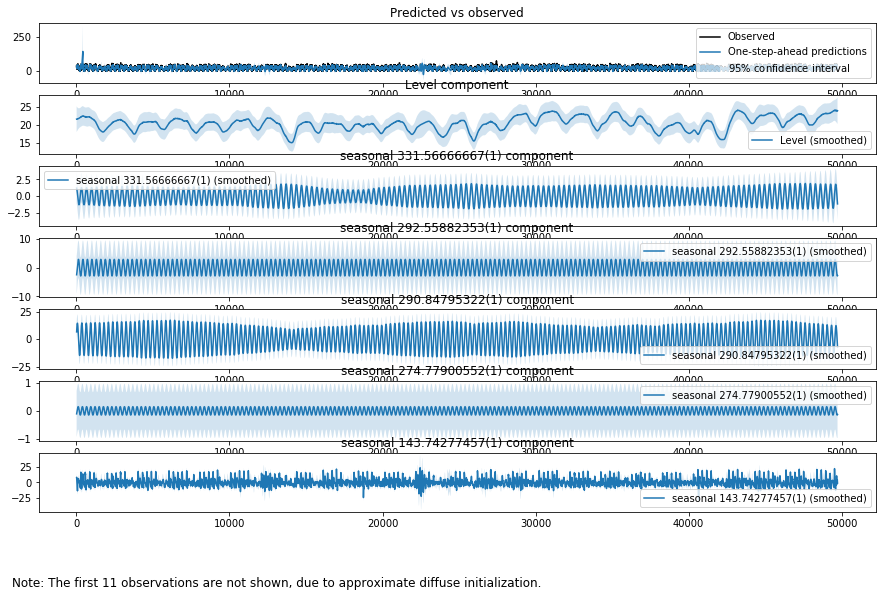

In [181]:
fig = output_res.plot_components(legend_loc='lower_right', figsize=(15,9))

In [182]:
simulate = output_res.get_prediction(0,len(rt)-1)

In [183]:
mean = simulate.predicted_mean

In [184]:
variance = simulate.var_pred_mean

In [233]:
def event_prob(data, prediction_mean, prediction_var):
    return (data-prediction_mean)**2/prediction_var

In [208]:
def difference(data, prediction_mean, prediction_var):
    return data-prediction_mean

In [259]:
event_probs = []

for i in data[1:67]:
        event_probs.append(event_prob(i[:,1].astype(np.float), mean[rt['Datetime'].isin(i[:,0].tolist())].values, variance[rt['Datetime'].isin(i[:,0].tolist())]))
        #print(len(event_probs)-1)
        #event_probs[len(event_probs)-1] = event_probs[len(event_probs)-1]-min(event_probs[len(event_probs)-1])
        #event_probs[len(event_probs)-1] = event_probs[len(event_probs)-1]/np.sum(event_probs[len(event_probs)-1])

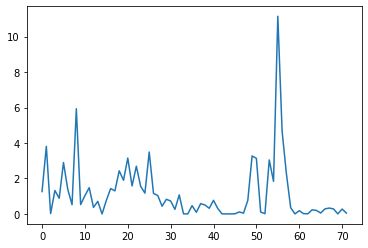

In [260]:
plt.plot((i[:,1].astype(np.float)-mean[rt['Datetime'].isin(i[:,0].tolist())].values)**2/variance[rt['Datetime'].isin(i[:,0].tolist())])

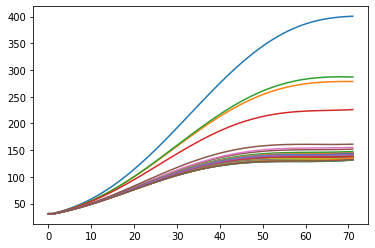

In [261]:
for i in data[1:67]:
    plt.plot(variance[rt['Datetime'].isin(i[:,0].tolist())])

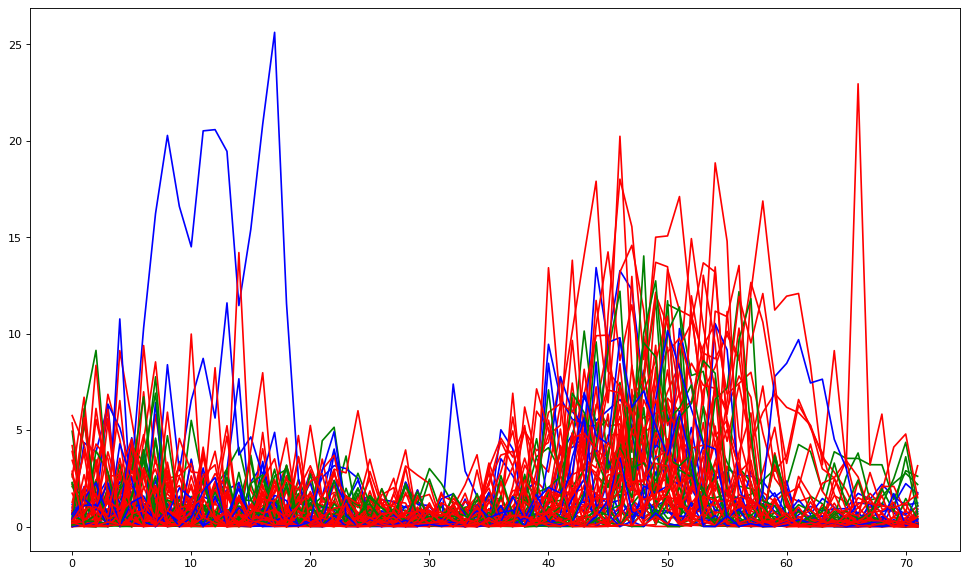

In [262]:
plt.figure(figsize=(15, 9), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        plt.plot(event_probs[i], color='blue')
    elif np.any(data[i][:,3] == 1):
        plt.plot(event_probs[i], color='green')
    elif np.any(data[i][:,4] == 1):
        plt.plot(event_probs[i],color='red')
    else:
        pass
        

In [247]:
event_mean = []
event_var = []

for i in range(len(event_probs)):    
    event_mean.append(np.sum(event_probs[i]*np.arange(72))/np.sum(event_probs[i]))
    event_var.append(np.sqrt(np.sum(event_probs[i]*(np.arange(72)-event_mean[i])**2)/np.sum(event_probs[i])))

In [248]:
#event_mean = []
#for i in range(len(event_probs)):
    #event_mean.append(np.sum(event_probs[i]*np.arange(72))/np.sum(event_probs[i]))

In [249]:
event_probs[i]

array([1.26007301e+00, 3.80940059e+00, 1.77310660e-02, 1.31991103e+00,
       8.83211035e-01, 2.89685848e+00, 1.38952355e+00, 5.20354155e-01,
       5.93042779e+00, 5.24834062e-01, 1.02894758e+00, 1.47800278e+00,
       3.67670558e-01, 7.07932440e-01, 2.49384283e-04, 7.63260874e-01,
       1.43099373e+00, 1.29807834e+00, 2.43102230e+00, 1.89879064e+00,
       3.14940584e+00, 1.57983794e+00, 2.68828907e+00, 1.55887855e+00,
       1.17265625e+00, 3.49053842e+00, 1.15519074e+00, 1.03743922e+00,
       4.35931694e-01, 8.24694883e-01, 7.29015085e-01, 2.57815018e-01,
       1.07326782e+00, 4.92044058e-03, 4.49630258e-04, 4.66180884e-01,
       9.06488536e-02, 5.81241291e-01, 5.02524149e-01, 3.18544186e-01,
       7.65687379e-01, 3.02437371e-01, 2.27904981e-03, 8.51018449e-06,
       1.26594789e-03, 5.39100148e-03, 1.10854023e-01, 4.26582691e-02,
       7.67714725e-01, 3.27092607e+00, 3.13212983e+00, 1.04661294e-01,
       1.23407724e-02, 3.04309335e+00, 1.83837443e+00, 1.11469919e+01,
      

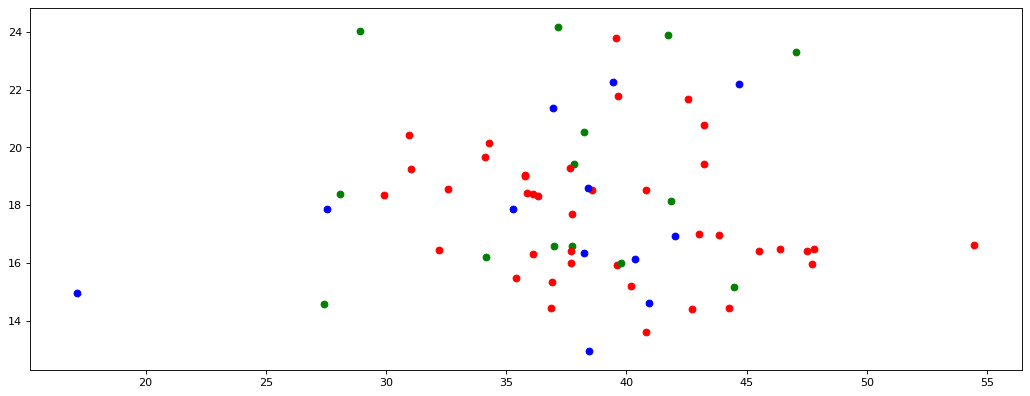

In [251]:
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(event_probs)):
    if np.any(data[i][:,2] == 1):
        plt.scatter(event_mean[i], event_var[i], color='blue')
    elif np.any(data[i][:,3] == 1):
        plt.scatter(event_mean[i], event_var[i], color='green')
    else:
        plt.scatter(event_mean[i], event_var[i], color='red')
        pass

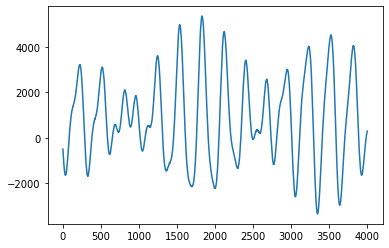

In [192]:
plt.plot(output_res.simulate(4000))